# To Eat, or Not to Eat?
## Part 2: Building models to predict whether mushrooms are edible or poisonous
### Sakshi and Abbie
### March 9, 2022

### Introduction

This notebook is a continuation of our mushroom project. The first notebook ("Part 1") detailed an exploratory analysis to provide an overall understanding of variable types and variable distributions. Now that we better understand our data, we can commence pre-processing and model-building.

As a reminder, this data was retrieved from the UCI Machine Learning repository. It details several characteristics about mushrooms and also classifies them by whether they are edible or poisonous. The data draws from The Audubon Society Field Guide to North American Mushrooms, published in 1981. 

The goal of this project is to construct a model with high precision, accuracy, and recall, which can predict whether a mushroom is edible or poisonous.

**Libraries and Data Set Required for Notebook**

In [196]:
# load initial libraries

# The basics
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
# For pre-processing
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
# For models
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
# For performance
from sklearn.metrics import classification_report
from sklearn.metrics import roc_curve, auc
from sklearn import metrics
from imblearn.combine import SMOTEENN
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import StratifiedKFold

In [197]:
# Read in the 1987 original data set
mushroom = pd.read_csv('1987_data.csv')

# View the first few rows
mushroom.head()

,class,cap-shape,cap-surface,cap-color,bruises,odor,gill-attachment,gill-spacing,gill-size,gill-color,...,stalk-surface-below-ring,stalk-color-above-ring,stalk-color-below-ring,veil-type,veil-color,ring-number,ring-type,spore-print-color,population,habitat
0,p,x,s,n,t,p,f,c,n,k,...,s,w,w,p,w,o,p,k,s,u
1,e,x,s,y,t,a,f,c,b,k,...,s,w,w,p,w,o,p,n,n,g
2,e,b,s,w,t,l,f,c,b,n,...,s,w,w,p,w,o,p,n,n,m
3,p,x,y,w,t,p,f,c,n,n,...,s,w,w,p,w,o,p,k,s,u
4,e,x,s,g,f,n,f,w,b,k,...,s,w,w,p,w,o,e,n,a,g


### Pre-processing

Fortunately, this data set is fairly clean and requires very minimal pre-processing. No resampling is needed, as the classes are fairly equally distributed. Only one variable ("stalk-root") contains missing values. All variables are categorical, meaning we can apply the same label encoding technique on all of them.

*Our pre-processing steps:*
1. Remove the "stalk-root" variable (too many are missing to be useful for analysis)
2. Convert all variables to numerical (necessary for machine learning algorithms) 
3. Determine import features
4. Implement appropriate feature engineering
5. Standardize variables

**Step 1: Handle Nulls**

Remove the stalk-root variable

In [198]:
# Drop the stalk root var
mushroom_df = mushroom.drop('stalk-root', axis=1)
mushroom_df.head()

,class,cap-shape,cap-surface,cap-color,bruises,odor,gill-attachment,gill-spacing,gill-size,gill-color,...,stalk-surface-below-ring,stalk-color-above-ring,stalk-color-below-ring,veil-type,veil-color,ring-number,ring-type,spore-print-color,population,habitat
0,p,x,s,n,t,p,f,c,n,k,...,s,w,w,p,w,o,p,k,s,u
1,e,x,s,y,t,a,f,c,b,k,...,s,w,w,p,w,o,p,n,n,g
2,e,b,s,w,t,l,f,c,b,n,...,s,w,w,p,w,o,p,n,n,m
3,p,x,y,w,t,p,f,c,n,n,...,s,w,w,p,w,o,p,k,s,u
4,e,x,s,g,f,n,f,w,b,k,...,s,w,w,p,w,o,e,n,a,g


**Step 2: Recode Variables and Convert to Numerical**

There are a few variables that we will recode into binary, based on some telling characteristics from our exploratory analysis. For the rest, we will use a simple label encoder, without any additional re-grouping. 

First, we will tackle the "odor" variable. The possible values are as follows:
- almond=a
- anise=l
- creosote=c
- fishy=y
- foul=f
- musty=m
- none=n
- pungent=p
- spicy=s

We can easily regroup this into a binary variable ("bad" smell vs. "not bad" smell). See code below.

In [199]:
# If the odor is "almond," "anise," or "none" group together as 0
# Else the odor is a bad odor, which is 1
mushroom_df['odor'] = np.where((mushroom_df['odor'] == 'a') | (mushroom_df['odor'] == 'l') | (mushroom_df['odor'] == 'n'), 
                               0, 1)

Next, we can re-code the "gill-color" variable to be "buff" or "other." Through the EDA, we learned that *all* mushrooms with a "buff" gill-color were poisonous. The other colors did not really distinguish much. Therefore, we can re-categorize the colors into "buff" (1) or "other" (0).

In [200]:
# If the gill color is "buff" (b) code as 1
# Else the gill color is "other"
mushroom_df['gill-color'] = np.where(mushroom_df['gill-color'] == 'b', 1, 0)

The last most informative variable (as determined by our EDA) was the "spore-print-color." As a refresher, the possible colors are:
- black=k
- brown=n
- buff=b
- chocolate=h
- green=r
- orange=o
- purple=u
- white=w
- yellow=y

We learned that the vast majority of mushrooms with a black (k) or brown (n) spore print color were edible. The vast majority of mushrooms with a chocolate (h) or white (w) spore print color were poisonous. The remaining colors were note as informative. Therefore, we can re-group into:
- black or brown = 1
- chocolate or white = 2
- other color = 3

In [201]:
# For smoothest method, create function for sole purpose of recoding this variable
def recode_spore(series):
    if series == 'k' or series == 'n':
        return 1
    elif series == 'h' or series == 'w':
        return 2
    else:
        return 3

# apply this function to the variable we want to recode
mushroom_df['spore-print-color'] = mushroom_df['spore-print-color'].apply(recode_spore)

In [202]:
# View the three vars that we just recoded and converted to numeric
mushroom_df[['odor', 'gill-color', 'spore-print-color']].head()

,odor,gill-color,spore-print-color
0,1,0,1
1,0,0,1
2,0,0,1
3,1,0,1
4,0,0,1


Next, we can apply the label encoder to all the other variables without any additional re-grouping.

In [203]:
# Function to label encode data set
def label_encode(df):
    # necessary import
    from sklearn.preprocessing import LabelEncoder
    # Instantiate the label encoder
    le = LabelEncoder()
    # Create deep copy
    df_new = df.copy()
    # create columns list
    col_list = df_new.columns
    # Iterate through str columns
    for var in col_list:
        if df_new[var].dtypes == 'O':
            # Complete transformation
            df_new[var] = le.fit_transform(df_new[var])
    # return new data frame
    return df_new

In [204]:
# Use function on data frame
mushroom_num = label_encode(mushroom_df)
# View data frame
mushroom_num.head()

,class,cap-shape,cap-surface,cap-color,bruises,odor,gill-attachment,gill-spacing,gill-size,gill-color,...,stalk-surface-below-ring,stalk-color-above-ring,stalk-color-below-ring,veil-type,veil-color,ring-number,ring-type,spore-print-color,population,habitat
0,1,5,2,4,1,1,1,0,1,0,...,2,7,7,0,2,1,4,1,3,5
1,0,5,2,9,1,0,1,0,0,0,...,2,7,7,0,2,1,4,1,2,1
2,0,0,2,8,1,0,1,0,0,0,...,2,7,7,0,2,1,4,1,2,3
3,1,5,3,8,1,1,1,0,1,0,...,2,7,7,0,2,1,4,1,3,5
4,0,5,2,3,0,0,1,1,0,0,...,2,7,7,0,2,1,0,1,0,1


**Step 3. Determine Important Features**

Before conducting the correlation matrix, we will view the distribution (between edible and poisonous), among all features in the data set. This can help us quickly visualize whether a variable could be meaningful in predicting whether a mushroom is safe to eat.

In [205]:
# Define function to display distributions among edible vs. poisonous
def violin(df, dependent_var):
    # Load necessary libraries
    import pandas as pd
    import seaborn as sns
    import matplotlib.pyplot as plt
    # unpivot the df from wide to long with pd.melt
    long_df = pd.melt(df, dependent_var, var_name='Characteristics')
    # set up axes
    fig, ax = plt.subplots(figsize=(20,8))
    # create violin plot
    sns.violinplot(x='Characteristics', y='value', hue='class', split = True, data=long_df, palette = 'prism')
    # drop the dependent variable
    features = df.drop([dependent_var],axis = 1)
    # Edit lables
    ax.set_xticklabels(rotation = 90, labels = list(features.columns), size=12)
    # Display plot
    plt.show()

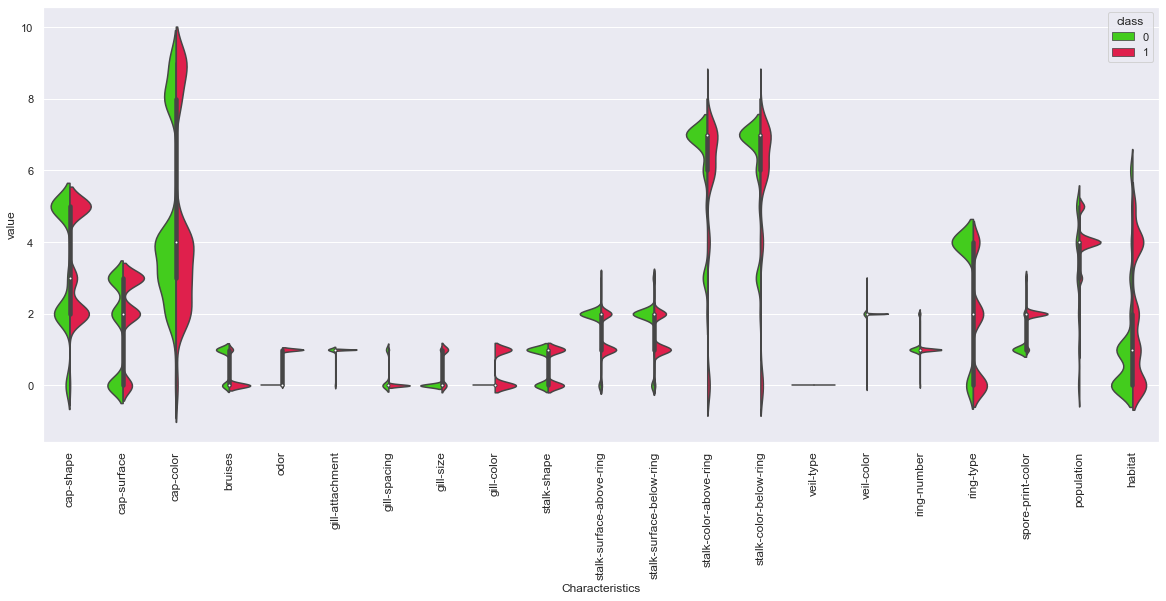

In [206]:
# Use function on data frame
violin(mushroom_num, 'class')

In the above plot, 0 represents "Edible" and 1 represents "Poisonous." 

The following variables seems to have a fairly similar distribution across classes:
* cap-shape
* cap-surface
* cap-color
* gill-attachment
* stalk shape
* veil-type
* veil-color
* ring-number

Therefore, these variables will likely not be very useful in predicting whether a mushroom is poisonous or not. We can, thus, remove them from our data set before computing the correlation matrix.

In [207]:
mushroom_num2 = mushroom_num.drop(['cap-shape', 'cap-surface', 'cap-color', 'gill-attachment', 'stalk-shape',
                                  'veil-type', 'veil-color', 'ring-number'], axis=1)
mushroom_num2.head()

,class,bruises,odor,gill-spacing,gill-size,gill-color,stalk-surface-above-ring,stalk-surface-below-ring,stalk-color-above-ring,stalk-color-below-ring,ring-type,spore-print-color,population,habitat
0,1,1,1,0,1,0,2,2,7,7,4,1,3,5
1,0,1,0,0,0,0,2,2,7,7,4,1,2,1
2,0,1,0,0,0,0,2,2,7,7,4,1,2,3
3,1,1,1,0,1,0,2,2,7,7,4,1,3,5
4,0,0,0,1,0,0,2,2,7,7,0,1,0,1


In [208]:
# create function to restructure dataframe in a way that works with triangular correlation matrix
def tri_corr_matrix(df):
    # import libraries
    import warnings
    warnings.filterwarnings('ignore')
    import numpy as np
    
    # absolute value so that color corresponds to magnitude of correlation, regardless of direction
    df_corr = abs(df.corr())
    
    # Reading code line from inside out...
        # Get shape of matrix
        # Use np.ones to replace all values with ones in the same shape as matrix
        # Wrap inside np.triu, in order to create an upper triangle of matrix
                # Upper diagonal of matrix are now 1s and lower diagonal of matrix are zeros
        # Create boolean where 1s are 'true' and 0s are 'false' (this is needed for mask function in next step)
        # mask the resulting array to be the same shape/type as the original df
                # We are only maintaining the values, where the boolean would be 'false'
    df_corr_tri = df_corr.mask(np.triu(np.ones(df_corr.shape)).astype(np.bool))
    # round values for easier reading
    df_corr_tri = df_corr_tri.round(2)
    # drop first row and last column because those will always be NaNs
    df_final = df_corr_tri.iloc[1::, :-1]
    # return df
    return df_final

In [209]:
# Implement function
mush_matrix = tri_corr_matrix(mushroom_num2)

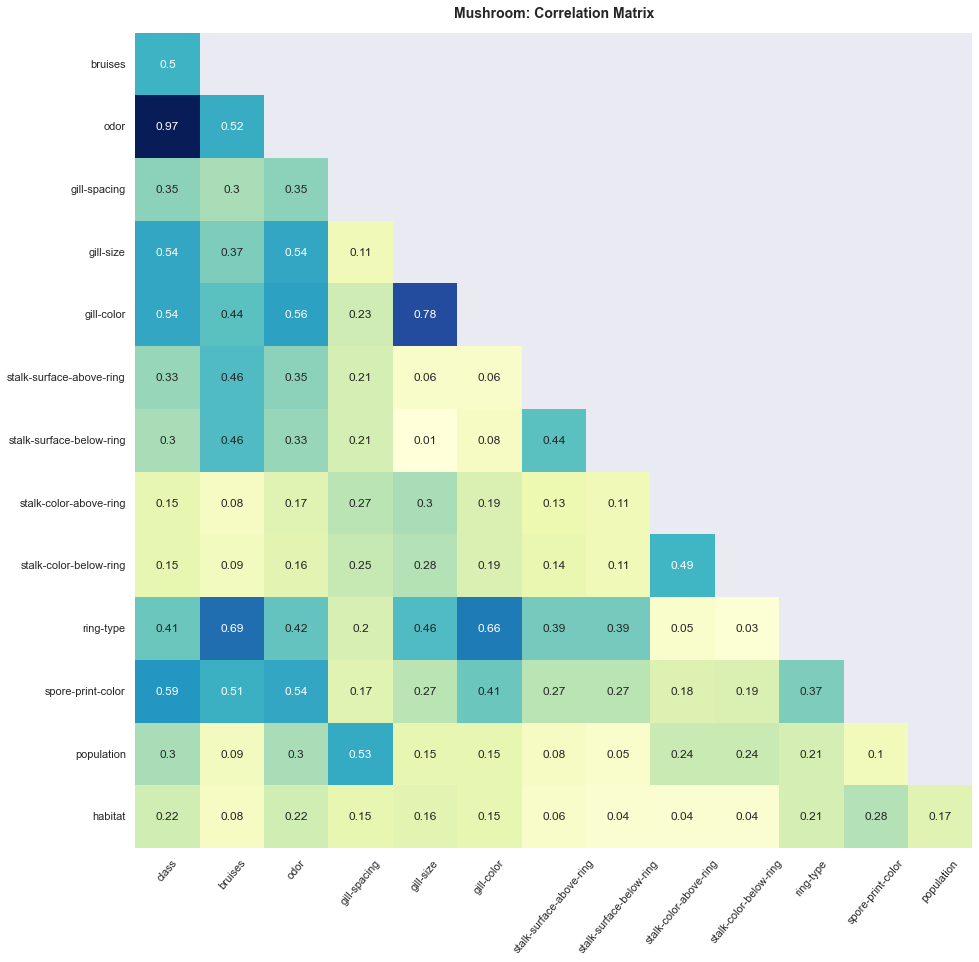

In [210]:
# Visualize matrix

# Set Figure Size
sns.set(rc={'figure.figsize':(15,15)})

# Visually display the matrix from above
# use the yellow-green-blue color map so that high correlations are more easily identifiable
h = sns.heatmap(mush_matrix, annot=True, cmap="YlGnBu", cbar=False)

# Add plot title 
h.set_title('Mushroom: Correlation Matrix', size=14, weight='bold', pad=15)

# rotate tick marks so they are easier to read
plt.xticks(rotation=50)

# Display plot
plt.show()

**Step 4: Feature Engineering**

As mentioned previously, the exploratory analysis suggested that the mushroom odor could be extremely indicative of whether it is posionous or edible. There is an extremely high correlation between odor and class (0.97). Meanwhile, odor does not have a high correlation with any other variable (i.e., there is no multi-collinearity). The second highest correlation was the "spore-print-color" (0.59). We might also find the "gill-size" and the "gill-color" useful (both with correlations of 0.54). Therefore, we will refine our data set to only have these variables. 

In [211]:
# Create refined data set with only those variables
mushroom_final = mushroom_num2[['odor', 'spore-print-color', 'gill-color', 'gill-size', 'class']]
mushroom_final.head()

,odor,spore-print-color,gill-color,gill-size,class
0,1,1,0,1,1
1,0,1,0,0,0
2,0,1,0,0,0
3,1,1,0,1,1
4,0,1,0,0,0


**Step 5: Standardize Variables**

Standardize variables and split into training vs. testing

In [212]:
# Get our predicted variables
X = mushroom_final.drop('class', axis=1)
# Get our outcome variable
y = mushroom_final['class']

# Split our data into training vs. testing
# We want to compute the model on our training data to train the model
# We then use that model on our testing data set to see the performance
X_train, X_test, y_train, y_test, = train_test_split(X, y, test_size = 0.3, random_state=33, stratify=y)

# Standardize our data
sc=StandardScaler()
# Standardize training values
X_train = sc.fit_transform(X_train)
# Standardize testing values
X_test=sc.fit_transform(X_test)

## Compute Models

In [259]:
def evaluate_model(y_test, y_pred, y_pred_prob):
    """Evaluate the performance of model using the test data. 
        Use accuracy score, precision, recall and confusion matrix as performance metrics."""
    from sklearn.metrics import classification_report, confusion_matrix
    
    # Find the AUC
    auc = metrics.roc_auc_score(y_test, y_pred_prob)

    # Display result
    print(f'\n\nArea Under the Curve (AUC): {round(auc*100,2)}%') 
    
    print("\n\n",classification_report(y_test, y_pred),
          "\n\nConfusion Matrix: ")
         
    
    confusion_matrix_ = metrics.confusion_matrix(y_test, y_pred)
    sns.heatmap(confusion_matrix_, annot=True, fmt="d")
    plt.xlabel("PREDICTED LABEL")
    plt.ylabel("TRUE LABEL")
    plt.show()

### Model 1: Logistic Regression

Logistic Regression training accuracy: 97.84%


Area Under the Curve (AUC): 99.9%


               precision    recall  f1-score   support

           0       0.97      0.99      0.98      1263
           1       0.99      0.97      0.98      1175

    accuracy                           0.98      2438
   macro avg       0.98      0.98      0.98      2438
weighted avg       0.98      0.98      0.98      2438
 

Confusion Matrix: 


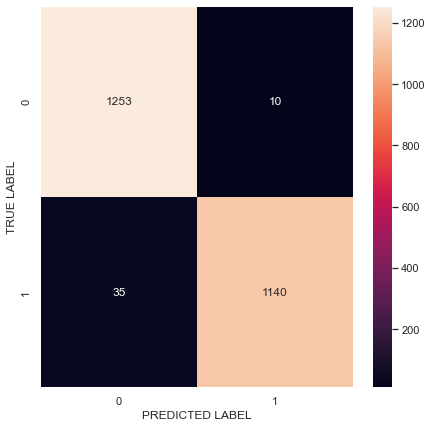

In [260]:
# Compute the logistic regression
# Fit it to the training data (train the model)
logreg_model = LogisticRegression(random_state=33).fit(X_train, y_train)

# Find the predicted values (predict edible or poisonous) on our testing data
y_pred_lr = logreg_model.predict(X_test)

y_pred_prob_lr = logreg_model.predict_proba(X_test)[::,1]

# Displaying model score
print(f"Logistic Regression training accuracy: {round(logreg_model.score(X_train, y_train)*100,2)}%")

# Evaluating basic model
evaluate_model(y_test, y_pred_lr, y_pred_prob_lr)

**Tune Model (using ROC curve)**

Currently, the logistic regression model is set to a default threshold of 0.5. This means that any mushroom with a predicted probability above 0.5 will be classified as 1=poisonous, while everything below 0.5 will be classified as 0=edible. On its own, this model is already remarkably accurate. However, we can still view threshold and try to boost even higher.


We will calculate the false positive rate (fpr) and the true positive rate (tpr) at every possible decision threshold. We will use this to plot a receiver operating characteristic (roc) curve. The value at which tpr is highest and fpr is lowest is the value we will use as our new threshold.

In [256]:
# fpr = false positive rate; tpr = true positive rate
fpr, tpr, thresholds = metrics.roc_curve(y_test, y_pred_prob_lr)

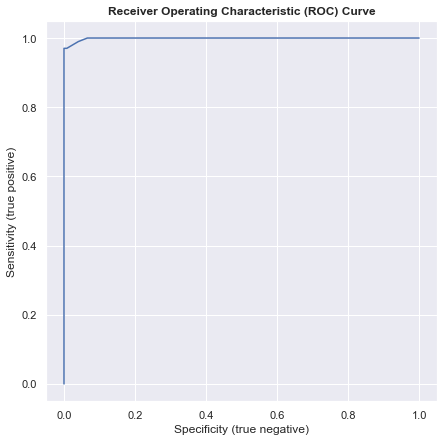

In [257]:
# Plot our ROC curve

# Set Figure Size
sns.set(rc={'figure.figsize':(7,7)})
# Plot false positive rate against true positive rate
plt.plot(fpr, tpr)
# Set labels
plt.ylabel('Sensitivity (true positive)')
plt.xlabel('Specificity (true negative)')
plt.title('Receiver Operating Characteristic (ROC) Curve', fontweight='bold')
# Show plot
plt.show()

    Unsurprisingly, our AUC is already nearly 100%, meaning our model does a wonderful job of predicting whether a mushroom is edible or poisonous.

    Moreover, from examining the ROC curve, it appears that the best threshold to optimize recall would be approximately 0.1. However, rather than estimate, we can be precise in calculating this threshold, according to the function below.

In [261]:
# Create function to determine the optimal threshold
def optimal_threshold(X_test, y_test):
    # necessary libraries
    from sklearn.metrics import roc_curve, auc
    from sklearn import metrics
    # extract the predicted probabilities
    y_pred_prob = logreg_model.predict_proba(X_test)[::,1]
    # unpack the fpr, tpr, and thresholds
    fpr, tpr, thresholds = metrics.roc_curve(y_test, y_pred_prob)
    # Best threshold is where the true positive rate is highest and false positive rate is lowest 
       # (i.e. the largest difference between the two)
    # Return the index of the maximum difference, so that we can find where the optimal threshold is located
    optimal = np.argmax(tpr - fpr) 
    # Extract the value that is located at the appropriate index of our threshold array
    optimal_threshold = thresholds[optimal]
    print(f'The optimal threshold value is: {optimal_threshold}')
    # Create ammended array with new values
    # Find where probabilities are greater than our calculated optimal threshold
    y_pred_tuned = np.where(y_pred_prob > optimal_threshold, 1, 0)
    # print the new classification report
    print(classification_report(y_test, y_pred_tuned))

In [262]:
# Implement function
optimal_threshold(X_test, y_test)

The optimal threshold value is: 0.9973635895139101
              precision    recall  f1-score   support

           0       0.88      1.00      0.94      1263
           1       1.00      0.85      0.92      1175

    accuracy                           0.93      2438
   macro avg       0.94      0.93      0.93      2438
weighted avg       0.94      0.93      0.93      2438



    Interestingly, when we apply the optimal threshold, the precision becomes 100%, while the recall drops quite considerably to 85%. Therefore, the default threshold of 0.5 is clearly superior for this model. 

    We can now try a different technique. Despite the sample sizes already being fairly equal, we can still experiment to see if SMOTE-ENN improves the overall performance of our model.

**More Tuning (using SMOTE-ENN)**

Logistic Regression training accuracy: 100.0%


Area Under the Curve (AUC): 99.88%


               precision    recall  f1-score   support

           0       0.97      1.00      0.99      1263
           1       1.00      0.97      0.98      1175

    accuracy                           0.99      2438
   macro avg       0.99      0.99      0.99      2438
weighted avg       0.99      0.99      0.99      2438
 

Confusion Matrix: 


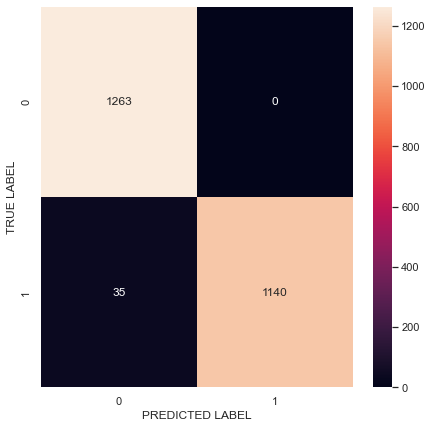

In [266]:
# Instantiate the classifier
sm = SMOTEENN(random_state=33, sampling_strategy='not majority', n_jobs=-1)

# Resample our data
X_res, y_res = sm.fit_resample(X_train, y_train)

# Compute the logistic regression
logreg_model_res = LogisticRegression(random_state=33).fit(X_res, y_res)

# Find the predicted values (predict edible or poisonous)
y_pred_res = logreg_model_res.predict(X_test)

y_pred_prob_res_lr = logreg_model_res.predict_proba(X_test)[::,1]

# Displaying model score
print(f"Logistic Regression training accuracy: {round(logreg_model_res.score(X_res, y_res)*100,2)}%")

# Evaluating basic model
evaluate_model(y_test, y_pred_res, y_pred_prob_res_lr)

    This model is the best so far! Clearly, the resampling method improved our model even more.

**More Tuning (using Grid Search + resampling)**

In [267]:
# create a dictionary of possible parameters to iterate through
param_dict = {"penalty": ['l1', 'l2', 'elasticnet', 'none'],
             "dual": [True, False],
             "fit_intercept": [True, False],
             "class_weight": ['balanced', None],
             "random_state": [33],
             "solver": ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga'],
             "multi_class": ['auto', 'ovr', 'multinomial'],
             "warm_start": [True, False]}

# instantiate the classifier
log = LogisticRegression()

In [268]:
# Run the decision tree model through the search, using the specified parameters and 20 crossfold validation
grid_log = GridSearchCV(log, 
                      param_grid = param_dict, 
                      cv=20,
                      scoring =['recall', 'precision'],
                      refit='recall')

# Fit the search to our training data
grid_log.fit(X_res, y_res)

# Print the tuned parameters and score
print("Tuned Logistic Regression Parameters: {}".format(grid_log.best_params_))

Tuned Logistic Regression Parameters: {'class_weight': 'balanced', 'dual': True, 'fit_intercept': True, 'multi_class': 'auto', 'penalty': 'l2', 'random_state': 33, 'solver': 'liblinear', 'warm_start': True}
Best logistic regression score is 1.0


Best logistic regression score is 1.0


Area Under the Curve (AUC): 99.9%


               precision    recall  f1-score   support

           0       0.97      0.99      0.98      1263
           1       0.99      0.97      0.98      1175

    accuracy                           0.98      2438
   macro avg       0.98      0.98      0.98      2438
weighted avg       0.98      0.98      0.98      2438
 

Confusion Matrix: 


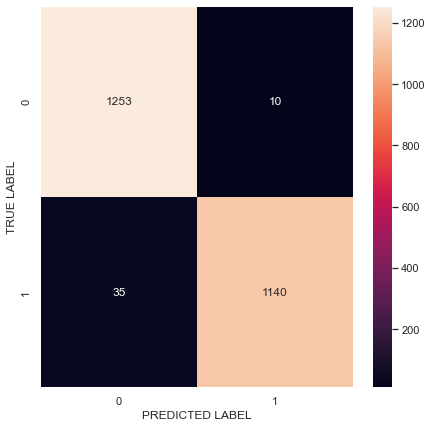

In [269]:
# Update model with revised parameters 
# Compute the logistic regression

logreg_model = grid_log.best_estimator_.fit(X_train, y_train)

# Find the predicted values (predict edible or poisonous)
y_pred = logreg_model.predict(X_test)

y_pred_prob = logreg_model.predict_proba(X_test)[::,1]

# Displaying model score
print("Best logistic regression score is {}".format(grid_log.best_score_))

# Evaluating basic model
evaluate_model(y_test, y_pred, y_pred_prob)

    Using the grid search did not change our scores from the original, despite changing a few of the parameters. However, it is still a highly accurate model. 

We will move on to other model types, just to compare.

## Model 2: KNN

KNN Model score: 98.51%


Area Under the Curve (AUC): 99.91%


               precision    recall  f1-score   support

           0       1.00      0.94      0.97      1263
           1       0.94      1.00      0.97      1175

    accuracy                           0.97      2438
   macro avg       0.97      0.97      0.97      2438
weighted avg       0.97      0.97      0.97      2438
 

Confusion Matrix: 


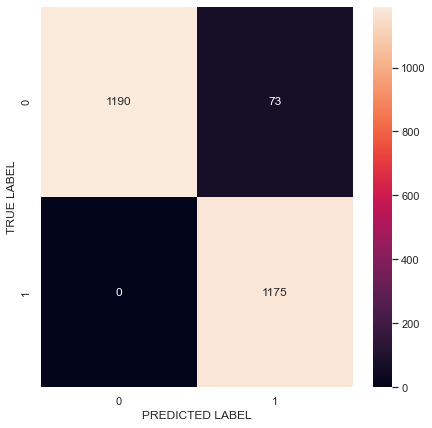

In [274]:
knn = KNeighborsClassifier(n_neighbors=3)
knn.fit(X_train, y_train)

y_pred_knn = knn.predict(X_test)
y_pred_prob_knn = knn.predict_proba(X_test)[::,1]

# Displaying model score
print(f"KNN Model score: {round(knn.score(X_train, y_train)*100,2)}%")

# Evaluate Model
evaluate_model(y_test, y_pred_knn, y_pred_prob_knn)

    Basic KNN Model with K=3 did well with accuracy of 97% and AUC score of 99.9%
Tuning model to find optimum K value.

**Tune Model**

In [232]:
knn = KNeighborsClassifier()

# Optimum K value is said to square root of no. of observations
opt_k = int(np.sqrt(mushroom_final.shape[0]))

knn_param = dict(n_neighbors=list(range(1, opt_k)))
  
# defining parameter range
grid_KNN = GridSearchCV(knn, knn_param, cv=10, scoring='accuracy', return_train_score=False,verbose=1)
  
# fitting the model for grid search
grid_knn_fit = grid_KNN.fit(X_train, y_train)

print("Best Score: ",grid_knn_fit.best_score_)
print("Best Params: ", grid_knn_fit.best_params_)

Fitting 10 folds for each of 89 candidates, totalling 890 fits
Best Score:  0.985050681947573
Best Params:  {'n_neighbors': 2}


Best score for KNN :  0.985050681947573


Area Under the Curve (AUC): 97.11%


               precision    recall  f1-score   support

           0       1.00      0.94      0.97      1263
           1       0.94      1.00      0.97      1175

    accuracy                           0.97      2438
   macro avg       0.97      0.97      0.97      2438
weighted avg       0.97      0.97      0.97      2438
 

Confusion Matrix: 


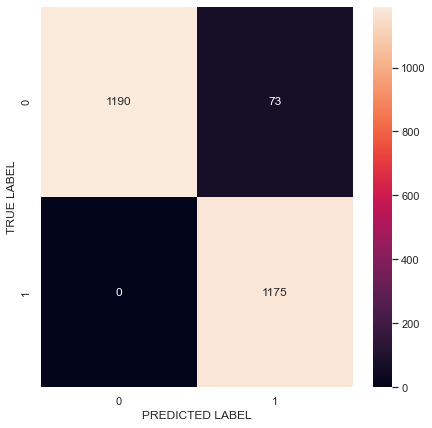

In [245]:
y_pred_knn = grid_knn_fit.predict(X_test)

y_pred_prob_knn = grid_knn_fit.predict_proba(X_test)[::,1]

print("Best score for KNN : ", grid_knn_fit.best_score_)
evaluate_model(y_test, y_pred_knn, y_pred_prob_knn)

    With GridSearchCV the optimum(k=2) KNN model performance is almost the same as what we ran with k=3 except for the AUC score which decreased from 99.91% to 97.11%
    
Will try ensemble learning method now.

## Model 3: Random Forest

**Tune Model**

Best score for RF :  0.985050681947573


Area Under the Curve (AUC): 99.91%


               precision    recall  f1-score   support

           0       0.97      1.00      0.99      1263
           1       1.00      0.97      0.98      1175

    accuracy                           0.99      2438
   macro avg       0.99      0.99      0.99      2438
weighted avg       0.99      0.99      0.99      2438
 

Confusion Matrix: 


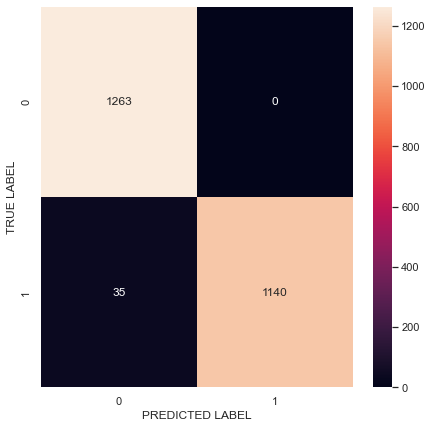

In [279]:
# Defining parameters for GridSearch of best Random Forest model
rf_params = {
        'max_features': ["auto", "sqrt", "log2"],
        'n_estimators': [300, 500, 700, 1000]
        }

# Using 10-fold CV to grid search best RF model
rf_grid_model = GridSearchCV(rf = RandomForestClassifier(random_state=25), rf_params, cv= 10, n_jobs= -1)
rf_grid_model.fit(X_train,y_train)

y_pred_rf = rf_grid_model.predict(X_test)

y_pred_prob_rf = rf_grid_model.predict_proba(X_test)[::,1]

print("Best score for RF : ", rf_grid_model.best_score_)

evaluate_model(y_test, y_pred_rf, y_pred_prob_rf)

    Random Forest model did well with accuracy score of 99% and auc score of 99.91%
    The model did as well as the tunes logistic regression model.

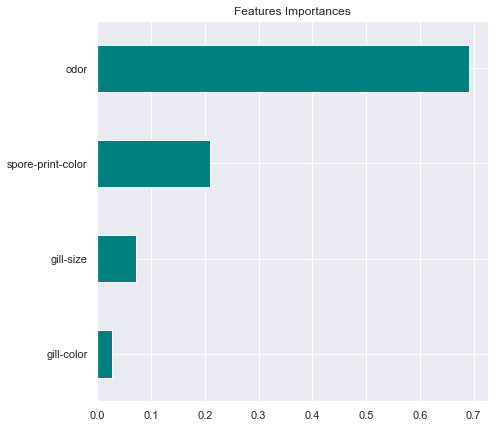

In [280]:
# Visualize which features are the most important 

# Create pandas series
importances = pd.Series(data=rf_grid_model.best_estimator_.feature_importances_,
                        index= X.columns)

# Sort importances
importances_sorted = importances.sort_values()

# Draw a horizontal barplot of importances_sorted
importances_sorted.plot(kind='barh', color='teal')
plt.title('Features Importances')
plt.show()

## Model 3: SVM Classification Model

Test Accuracy: 98.56%


Area Under the Curve (AUC): 99.91%


               precision    recall  f1-score   support

           0       0.97      1.00      0.99      1263
           1       1.00      0.97      0.98      1175

    accuracy                           0.99      2438
   macro avg       0.99      0.99      0.99      2438
weighted avg       0.99      0.99      0.99      2438
 

Confusion Matrix: 


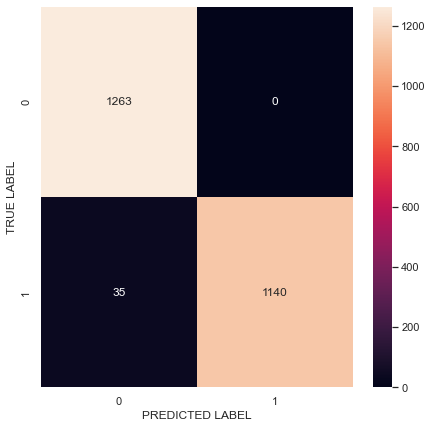

In [306]:
from sklearn.svm import SVC

# Defining paramters for grid search of best SVM 

grid_svm = {'C': [0.1, 1, 10, 100, 1000],
'gamma': [1, 0.1, 0.01, 0.001, 0.0001]}

# Using 10-fold CV to find the best SVM
svm = GridSearchCV(SVC(random_state=25, probability=True), grid_svm, cv = 10)

svm.fit(X_train, y_train)

print("Test Accuracy: {}%".format(round(svm.score(X_test, y_test)*100, 2)))

y_pred_svm = svm.predict(X_test)
y_pred_prob_svm = svm.predict_proba(X_test)[::,1]

evaluate_model(y_test, y_pred_svm, y_pred_prob_svm)

    SVM did well with accuracy score of 99% and auc score of 99.91%, same as Random Forest Model.

## Final Thoughts and Conclusions

If you have any doubt whether a mushroom is poisonous or edible, you might just need to do a "sniff" test! If the odor is unpleasant, it is almost certainly poisonous. Otherwise, the mushroom is likely safe to eat.

**Which model was the best?**

Random Forest Model and SVM Model both performed equally with accuracy of 99% and AUC score of 99.91%
Interestingly we achielved the same level of performance my fine tuning Logistic Regression model.

**How we determined which model is the best.**

There are several way to evaluate classification model's performance. Like :
    * Precision/Recall
    * Accuracy score
    * AUC score

Considering all these parameters we evaluated our models.

**How we tested for over/under fitting**

We have a dataste here which is all categorical features predicting categorical target variable. 
As there was no continious data variable, we wanted avoid overfitting from the very beginning.
Few steps we took as part of preprocessing were:

    1. We dropped attributes whose values were fairly distributed across class. 
    2. After feature selection we generalized the categorical variables wherever possible to avoid overfitting.
       Like, classifying various odors under please smell and not pleasant smell.

Steps taken while tuning models: 

    1. Splitting our data into training vs. testing 
    2. Utilizing a crossfold validation in our grid searches
    3. Using ensemble learning models like Random Forest

**Some lessons learned**

One large lesson learned is that the exploratory portion of analysis can be instrumental to model-building. For instance, we first conducted the simple label encoder on all our variables in the data set, without any recoding at all. This yielded decent performance, but did not seem to be as performative as it could be. However, we than revisited our "Part 1" (EDA) to explore further. We analyzed the feature distribution, separated by class (whereas before we had not separated them). This revealed the single most import indicator of whether a mushroom was edible or poisonous: Odor. Despite there being 9 categories, there was a stark divide between edible and poisonous.

This leads to the next lesson learned of the importance of properly recoding variables. Originally, we had used the label encoder on "odor" creating 0-8 numeric values. When we ran the correlation matrix, the correlation between odor and class was 0.09, so we did not even include it in our models. After grouping the odors into "bad" odors vs "good" odors (making the variable binary), the correlation between odor and class jumped way up to 0.97. We then included this variable in our models and had incredible accuracy. 